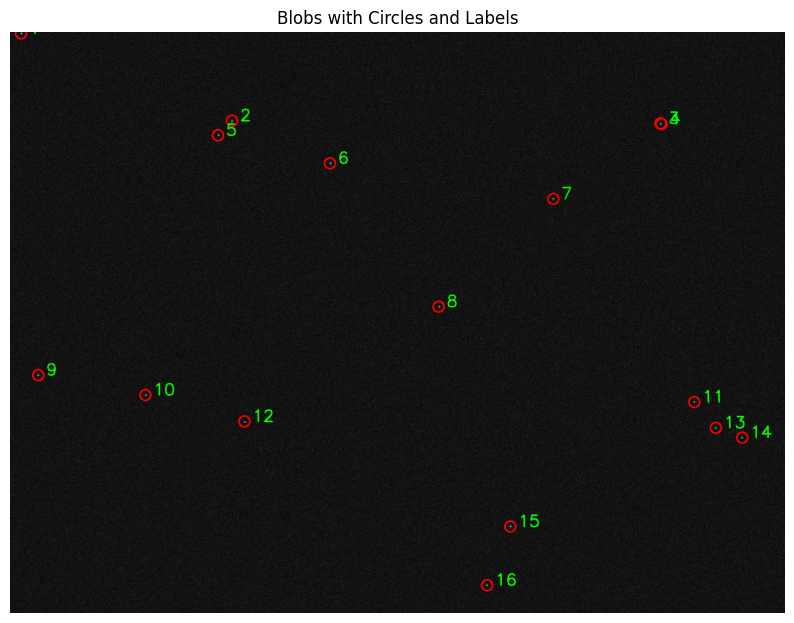

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass
import lmfit
%matplotlib inline

# Load the image (use tifffile if needed)
image = cv2.imread('microscopy_image.tiff', cv2.IMREAD_GRAYSCALE)

# Threshold to create a binary image
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Detect blobs using connected-component analysis
structure = np.ones((3, 3), dtype=int)  # Define connectivity
labeled, num_features = label(binary, structure=structure)

# Get blob centers
blob_centers = center_of_mass(binary, labeled, range(1, num_features + 1))

# Clone the original image to draw circles and labels on it
image_with_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for color circles

# Draw circles and labels around each blob center
for i, center in enumerate(blob_centers):
    x, y = int(center[0]), int(center[1])
    radius = 10  # Set a fixed radius or calculate dynamically
    cv2.circle(image_with_circles, (y, x), radius, (0, 0, 255), 2)  # Red circle
    label_text = str(i + 1)  # Label as the index of the blob
    cv2.putText(image_with_circles, label_text, (y + 15, x), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with circles and labels using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image_with_circles, cv2.COLOR_BGR2RGB))
plt.title("Blobs with Circles and Labels")
plt.axis('off')
plt.show()

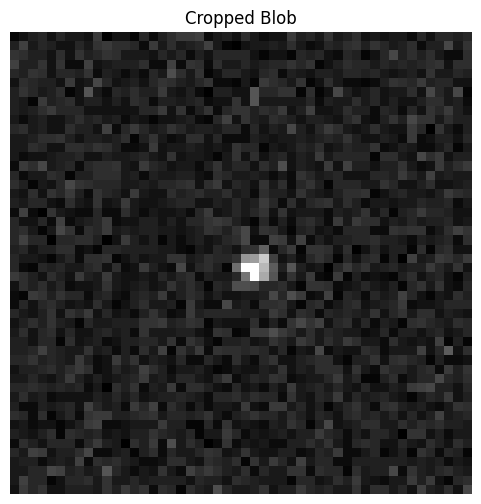

In [2]:
# Function to crop around a specific blob by index (using zero-based index)
def crop_blob(image, blob_centers, index, crop_size=50):
    # Ensure the index is within bounds
    if 0 <= index < len(blob_centers):
        # Get the coordinates of the selected blob
        x, y = int(blob_centers[index][0]), int(blob_centers[index][1])

        # Define crop boundaries
        x_start, x_end = max(0, x - crop_size // 2), min(image.shape[0], x + crop_size // 2)
        y_start, y_end = max(0, y - crop_size // 2), min(image.shape[1], y + crop_size // 2)

        # Crop the image around the blob
        cropped_image = image[x_start:x_end, y_start:y_end]
        return [cropped_image, [x_start, y_start]]
    else:
        print("Invalid index!")
        return None

# plot le point avec le label suivant :
label = 10

# Example of cropping around the 3rd blob (index = 2, zero-based indexing) 
crop = crop_blob(image, blob_centers, index=label-1)
cropped_image = crop[0]
crop_coord = crop[1]

# Display the cropped image using matplotlib
if cropped_image is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_image, cmap='gray')
    plt.title("Cropped Blob")
    plt.axis('off')
    plt.show()

In [3]:
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    a = 1 / (2 * sigma_x**2)
    b = 1 / (2 * sigma_y**2)
    return offset + amplitude * np.exp(- (a * (x - x0)**2 + b * (y - y0)**2))

In [4]:
def prepare_data(x, y, z):
    return (x.flatten(), y.flatten()), z.flatten()

In [5]:
intensity_grid = cropped_image

In [6]:
x = np.arange(intensity_grid.shape[0])
y = np.arange(intensity_grid.shape[1])
X, Y = np.meshgrid(x, y)

In [7]:
(xdata, ydata), zdata = prepare_data(X, Y, intensity_grid)

# Create lmfit model and initial parameters
model = lmfit.Model(gaussian_2d)

# Find the indices of the maximum intensity
max_idx = np.unravel_index(np.argmax(intensity_grid), intensity_grid.shape)

# Convert the indices to coordinates
initial_x0 = x[max_idx[1]]  # x-coordinate
initial_y0 = y[max_idx[0]]  # y-coordinate

params = model.make_params(
    amplitude=np.max(intensity_grid),
    x0=initial_x0,
    y0=initial_y0,
    sigma_x=10,
    sigma_y=10,
    offset=0
)

# Perform the fit
result = model.fit(zdata, params, xy=(xdata, ydata))
result

Point moyen = (26.01, 25.08) pixels


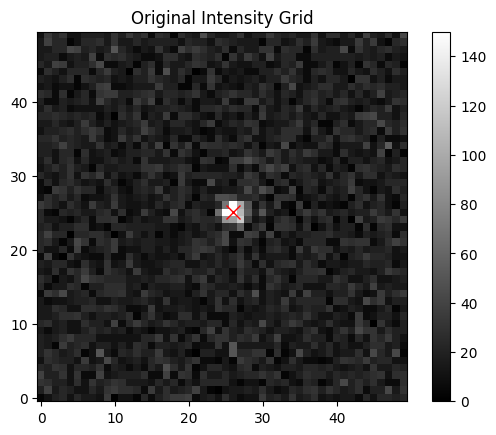

In [8]:
# Plot the original and fitted intensity grids
Z_fit = result.best_fit.reshape(X.shape)

# Extract the fitted parameters for the mean of the Gaussian
x0_fit = result.params['x0'].value
y0_fit = result.params['y0'].value

print(f"Point moyen = ({x0_fit:.2f}, {y0_fit:.2f}) pixels")

# Plot the original and fitted intensity grids using imshow
plt.figure()

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.imshow(intensity_grid, origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.plot(x0_fit, y0_fit, 'rx', markersize=10)  # Plot cross at the mean of the Gaussian

In [9]:
fitx = x0_fit + crop_coord[0] - 1
fity = x0_fit + crop_coord[1]

# interactive plotting in separate window
%matplotlib tk
plt.imshow(image, origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.plot(fity, fitx, 'rx', markersize=10)  # Plot cross at the mean of the Gaussian